In [1]:
import pandas as pd
import nltk
import re
# import csv
import matplotlib.pyplot as plt 
import seaborn as sns
# import sqlalchemy
from sqlalchemy import create_engine
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline
pd.set_option('display.max_colwidth', 300)


In [2]:
rds_connection_string = f"roo2:123456@netflix.cy8gt7mz64dd.us-east-2.rds.amazonaws.com:5432/postgres"
engine = create_engine(f'postgresql://{rds_connection_string}')
movies_list = pd.read_sql_query('''SELECT t.title, t.rating, t.description\
                        FROM public."Title" t\
                        WHERE t.rating is not null''', engine)
movies_list.head()

,title,rating,description
0,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first."
1,Jandino: Whatever it Takes,TV-MA,"Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of ""Sex on Fire"" in his comedy show."
2,Transformers Prime,TV-Y7-FV,"With the help of three human allies, the Autobots once again protect Earth from the onslaught of the Decepticons and their leader, Megatron."
3,Transformers: Robots in Disguise,TV-Y7,"When a prison ship crash unleashes hundreds of Decepticons on Earth, Bumblebee leads a new Autobot force to protect humankind."
4,#realityhigh,TV-14,"When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity."


In [3]:
ratings_df = pd.DataFrame(movies_list['rating'].value_counts())
ratings_df.reset_index()
ratings_df

,rating
TV-MA,2027
TV-14,1698
TV-PG,701
R,508
PG-13,286
NR,218
PG,184
TV-Y7,169
TV-G,149
TV-Y,143


In [4]:
# NR and UR are essentially null data -- there is no rating -- so drop those records
rated_movies_list = movies_list.drop(movies_list[(movies_list['rating'] == 'NR') | (movies_list['rating'] == 'UR')].index)
rated_movies_list

,title,rating,description
0,Norm of the North: King Sized Adventure,TV-PG,"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first."
1,Jandino: Whatever it Takes,TV-MA,"Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of ""Sex on Fire"" in his comedy show."
2,Transformers Prime,TV-Y7-FV,"With the help of three human allies, the Autobots once again protect Earth from the onslaught of the Decepticons and their leader, Megatron."
3,Transformers: Robots in Disguise,TV-Y7,"When a prison ship crash unleashes hundreds of Decepticons on Earth, Bumblebee leads a new Autobot force to protect humankind."
4,#realityhigh,TV-14,"When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity."
...,...,...,...
6218,La Familia P. Luche,TV-14,"This irreverent sitcom featues Ludovico, Federica and their three children Bibi, Junior and Ludoviquito, living in Ciudad P. Luche."
6219,The Adventures of Figaro Pho,TV-Y7,"Imagine your worst fears, then multiply them: Figaro is a boy with any number of phobias and a highly quirky and imaginative way of dealing with them."
6220,Kikoriki,TV-Y,"A wacky rabbit and his gang of animal pals have fun solving problems, sharing stories and exploring their sometimes magical, always special world."
6222,Maron,TV-MA,"Marc Maron stars as Marc Maron, who interviews fellow comedians for his popular podcast, only to reveal more about his own neuroses and relationships."


In [5]:
# Consolidate ratings to eliminate close matches and improve predictive model
rated_movies_list.replace(regex={'TV-MA': 'R'}, inplace=True)
rated_movies_list.replace(to_replace ="TV-14",
                 value ="PG-13", inplace=True)
rated_movies_list.replace(to_replace =["TV-Y7","TV-G","TV-Y","TV-Y7-FV"],
                 value ="G", inplace=True)
rated_movies_list.replace(to_replace ="TV-PG",
                 value ="PG", inplace=True)


In [6]:
rated_movies_list["rating"] = rated_movies_list["rating"].str.split('\s*,\s*')
rated_movies_list["rating"].explode().nunique()

5

In [7]:
grouped = rated_movies_list.groupby('rating')
grouped

In [8]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text


rated_movies_list['clean_description'] = rated_movies_list['description'].apply(lambda x: clean_text(x))
rated_movies_list.head()

,title,rating,description,clean_description
0,Norm of the North: King Sized Adventure,[PG],"Before planning an awesome wedding for his grandfather, a polar bear king must take back a stolen artifact from an evil archaeologist first.",before planning an awesome wedding for his grandfather a polar bear king must take back a stolen artifact from an evil archaeologist first
1,Jandino: Whatever it Takes,[R],"Jandino Asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of ""Sex on Fire"" in his comedy show.",jandino asporaat riffs on the challenges of raising kids and serenades the audience with a rousing rendition of sex on fire in his comedy show
2,Transformers Prime,[G],"With the help of three human allies, the Autobots once again protect Earth from the onslaught of the Decepticons and their leader, Megatron.",with the help of three human allies the autobots once again protect earth from the onslaught of the decepticons and their leader megatron
3,Transformers: Robots in Disguise,[G],"When a prison ship crash unleashes hundreds of Decepticons on Earth, Bumblebee leads a new Autobot force to protect humankind.",when a prison ship crash unleashes hundreds of decepticons on earth bumblebee leads a new autobot force to protect humankind
4,#realityhigh,[PG-13],"When nerdy high schooler Dani finally attracts the interest of her longtime crush, she lands in the cross hairs of his ex, a social media celebrity.",when nerdy high schooler dani finally attracts the interest of her longtime crush she lands in the cross hairs of his ex a social media celebrity


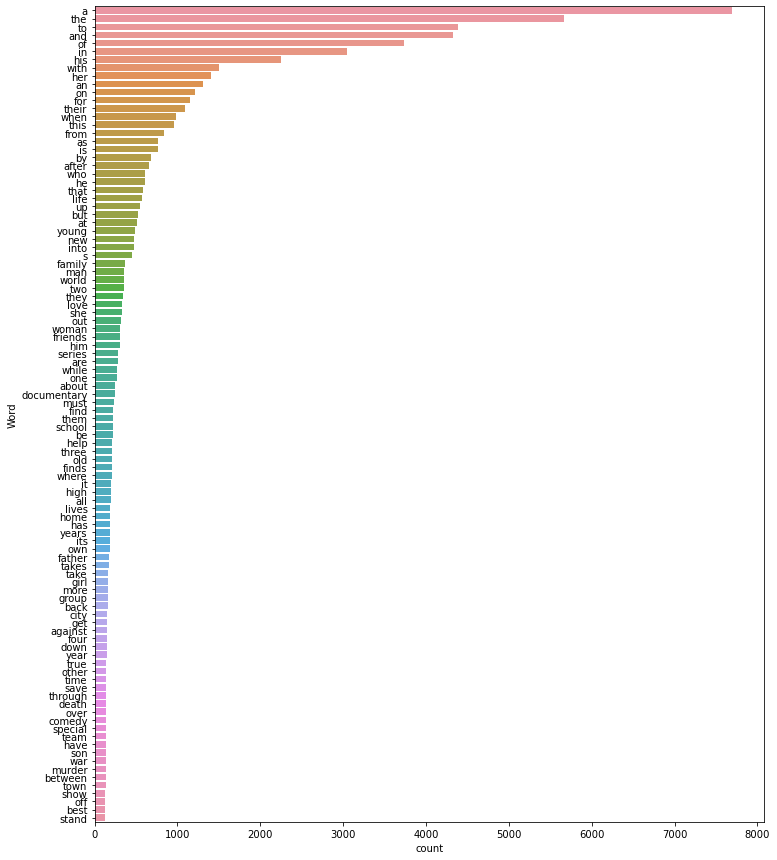

In [9]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(rated_movies_list['clean_description'], 100)

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

rated_movies_list['clean_description'] = rated_movies_list['clean_description'].apply(lambda x: remove_stopwords(x))

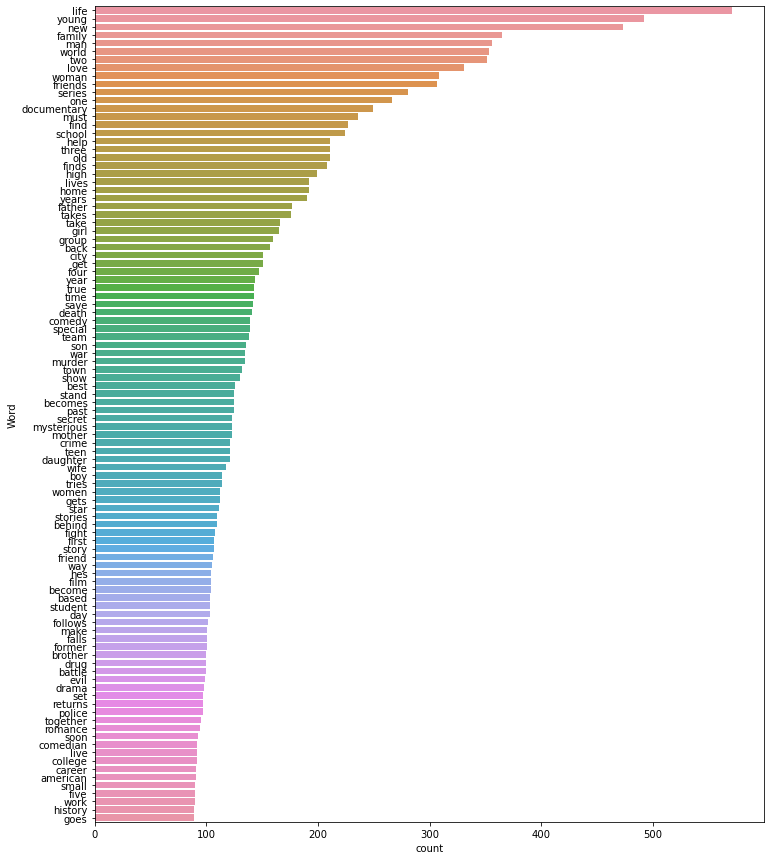

In [12]:
freq_words(rated_movies_list['clean_description'], 100)

In [13]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer_rating = MultiLabelBinarizer()
multilabel_binarizer_rating.fit(rated_movies_list['rating'])

# transform target variable
y = multilabel_binarizer_rating.transform(rated_movies_list['rating'])

In [137]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=400)

In [138]:
xtrain, xval, ytrain, yval = train_test_split(rated_movies_list['clean_description'], y, test_size=.12, random_state=9)

In [139]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [140]:
from sklearn.linear_model import LogisticRegression

#Binary relevance
from sklearn.multiclass import OneVsRestClassifier

#Performance metric
from sklearn.metrics import f1_score

In [141]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [142]:
LogRegRating_pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('clf', OneVsRestClassifier(LogisticRegression()))
    
                           ])
LogRegRating_pipeline.fit(xtrain, ytrain)

Pipeline(steps=[('vectorizer', TfidfVectorizer(max_df=0.5, max_features=400)),
                ('clf', OneVsRestClassifier(estimator=LogisticRegression()))])

In [143]:
# fit model on train data
# clf.fit(xtrain_tfidf, ytrain)

In [144]:
# make predictions for validation set
y_pred = LogRegRating_pipeline.predict(xval)

In [145]:
y_pred[3]

array([0, 0, 0, 0, 1])

In [146]:
multilabel_binarizer_rating.inverse_transform(y_pred)[3]

('R',)

In [147]:
# evaluate performance
f1_score(yval, y_pred, average="micro")


0.3516908212560386

In [148]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
#     q_vec = tfidf_vectorizer.transform([q])
    q_pred = LogRegRating_pipeline.predict([q])
    return multilabel_binarizer_rating.inverse_transform(q_pred)

In [149]:
for i in range(10): 
    k = xval.sample(1).index[0] 
    print("Movie: ", rated_movies_list['title'][k], "\nPredicted rating: ", infer_tags(xval[k])), print("Actual rating: ",rated_movies_list['rating'][k], "\n")

Movie:  Single 
Predicted rating:  [()]
Actual rating:  ['PG'] 

Movie:  John Mellencamp: Plain Spoken 
Predicted rating:  [()]
Actual rating:  ['R'] 

Movie:  God's Own Country 
Predicted rating:  [('R',)]
Actual rating:  ['R'] 

Movie:  Nothing to Hide 
Predicted rating:  [()]
Actual rating:  ['R'] 

Movie:  Sunrise 
Predicted rating:  [('R',)]
Actual rating:  ['R'] 

Movie:  Star Trek: Enterprise 
Predicted rating:  [()]
Actual rating:  ['PG'] 

Movie:  Robozuna 
Predicted rating:  [()]
Actual rating:  ['G'] 

Movie:  Between 
Predicted rating:  [('PG-13',)]
Actual rating:  ['PG-13'] 

Movie:  마녀사냥 
Predicted rating:  [('R',)]
Actual rating:  ['R'] 

Movie:  Marco Polo 
Predicted rating:  [()]
Actual rating:  ['R'] 



In [27]:
infer_tags('unconventional high school philosophy teacher upsets parents staff romances others inspires pupils including gay son')

[()]

In [28]:
test_desc = "There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, “Oh dear! Oh dear! I shall be late!” (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before seen a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge."

print("Movie: ", "Silent Hill", "\nPredicted rating: ", infer_tags(test_desc)), print("Actual rating: ","R", "\n")

Movie:  Silent Hill 
Predicted rating:  [()]
Actual rating:  R 



(None, None)

In [29]:
# from joblib import dump, load
# dump(LogReg_pipeline, 'description_genre.joblib') 
import pickle
with open('description_rating.pkl', 'wb') as r:
    pickle.dump((multilabel_binarizer_rating, LogRegRating_pipeline), r)